# Figure 1: Clustering Scientific Respository Contents using UMAP

This notebook is using Uniform Manifold Approximation and Projection (or UMAP) clustering for different data collections (each represented
by a dot) across different, well-known repositories (figures). The clustering is performed using the distribution of number of
entries (i.e., files or objects) and their frequency (i.e., histogram of file sizes or object sizes). The plots are a proxy for the
repositories’ diversity: the more disperse the dots, the more diverse the entries.

As different repositories use different terminology, in the accompanying paper we adopted the following abstract definitions:

* An entry corresponds to entities at the file or object granularity as defined by a repository.
* A collection corresponds to entities describing multiple entries. Many repositories refer to collections also as datasets, but because dataset is very overloaded we opt to avoid the term here (e.g., many entries are HDF5 files which internally also have datasets).

### Prerequisites

[//]: # "**NOTE**: The step to set up clickhouse and downloading the full data may be skipped when using the sample that comes with this repository. In that case proceed to *Section: Prepare UMAP Clustering*."

__Setup Clickhouse:__ The clusterings are obtained by sampling the data directly from the database instance thus, to re-run the full analysis is is necessary to populate a clickhouse instance first. How to best set this up depends on the system, an easy way to run this is using the offical clickhouse-server Docker container available here:

* https://hub.docker.com/r/yandex/clickhouse-server

__Download and Import Data:__ In addition you will need to download and import the data CSV file containing entries for various scanned repositories (just under 300 GiB).
The datafiles can be downloaded from the following location (requires a S3 client). Please refer to the instruction to download:

 * https://github.com/nsdf-fabric/nsdf-catalog/tree/main/src/python/nsdf-crawler#crawled-results

Downloading the CSV files for all repositories (~1700+) is possible for example using the following AWS S3 command-line:

```
aws s3 --no-sign-request --endpoint-url=https://s3.us-west-1.wasabisys.com cp --recursive s3://nsdf-catalog-crawler /location/to/copy/to
```


__Install dependencies:__ This notebook requires the following dependencies in addition to the ones listed in the "requirements.txt":

Ensure the following import work:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
from clickhouse_driver import Client

## Connect to Clickhouse

In [ ]:
from clickhouse_driver import Client

CLICKHOUSE_HOST = "localhost" # assuming the docker container is running locally, otherwise add IP or hostname running clickhouse
CLICKHOUSE_PORT = "9000"
CLICKHOUSE_USER = "admin"
CLICKHOUSE_PASSWORD = "your-clickhouse-password"

secure = False # You may 
client = Client(host=CLICKHOUSE_HOST, port=str(CLICKHOUSE_PORT), user=CLICKHOUSE_USER, password=CLICKHOUSE_PASSWORD, secure=secure)

In [ ]:
# Please verify the connection was established and the database with the index is shown
print(client.execute('SHOW DATABASES'))

## UMAP Clustering

### Define Fingerprint Structure used for Datasets

Since clustering based on all the raw data quickly becomes prohibitively expensive. The dataset fingerprint selects a number of relevant features, here the histogram of filesizes in each dataset.

In [ ]:
FINGERPRINT_SIZE = 64

def generate_fingerprint(bucket):
    bucket_name = bucket.bucket
    catalog_name = bucket.catalog

    entries = client.execute(f"""
    SELECT 
        name,
        size
    FROM nsdf.catalog 
    WHERE 
        catalog = '{catalog_name}' AND
        bucket = '{bucket_name}'
    """)
    
    entries_df = pd.DataFrame(entries)    
    fingerprint = np.histogram(entries_df[1].to_numpy(), bins=64)[0]

    return fingerprint

### Obtain Samples

In [ ]:
OUTPUT_DIR = "../data/figure1"
COLLECTION_CACHE_FILENAME = "tmp_select-bucket-catalog-count-sum.csv"

Find all collection from all repositories (collections in the raw data are called buckets):

In [ ]:
%%time

QUERY="""SELECT bucket, catalog, COUNT(*), SUM(size) FROM nsdf.catalog GROUP BY bucket, catalog"""
cachefile = f"{OUTPUT_DIR}/{COLLECTION_CACHE_FILENAME}"


import pathlib
import pandas as pd

if pathlib.Path(cachefile).exists():
    buckets_df = pd.read_csv(cachefile) 
    buckets_df = buckets_df.drop("Unnamed: 0", axis=1)
else:
    # reference Wall time with clickhouse: 1min 47s
    buckets = client.execute(QUERY)    
    buckets_df = pd.DataFrame(buckets)
    del buckets
    buckets_df.to_csv(cachefile)

buckets_df.columns = ["bucket", "catalog", "count", "sum"]
buckets_df.head()

The next step is to sub-sample from the list of all available collections 

In [ ]:
samples = buckets_df.groupby(["catalog"]).sample(n=200, replace=True)
num_samples = len(samples)
num_samples

The following step generates fingerprints for each collection in the population of samples.

**Note:** This step requires the Clickhouse backend to be running:


In [ ]:
%%time
# Generate fingerprint for every collection 
# Expect to run for about ~10 minutes

print("num_samples:", num_samples)

# generate fignerprints (requires clickhouse backend)
buckets_data = samples.apply(lambda row: generate_fingerprint(row), axis=1)
fingerprint_size = buckets_data.iloc[0].shape[0]

# parameters used later
data_to_cluster = np.hstack(buckets_data.to_numpy()).reshape(num_samples, fingerprint_size)
c = len(buckets_data)

### Reduce Dimensions and Extract Embedding

In [ ]:
%%time
# Expect to run for about 1 minute

reducer = umap.UMAP(random_state=42)
reducer.fit(data_to_cluster)

In [22]:
%%time
# This should return immedietly

embedding = reducer.transform(data_to_cluster)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

CPU times: user 6.41 ms, sys: 0 ns, total: 6.41 ms
Wall time: 5.34 ms


(10000, 2)

## Combined Cluster Map

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif


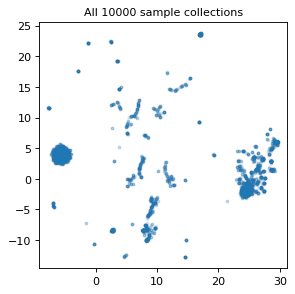

In [63]:
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=80)


plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    cmap='Spectral', 
    s=5,
    alpha=0.05
)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title(f'All {num_samples} sample collections', fontsize=10);

#### Generate Figures for Figure 1

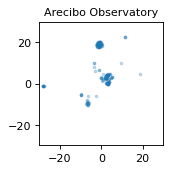

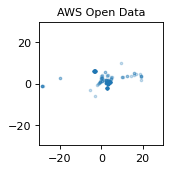

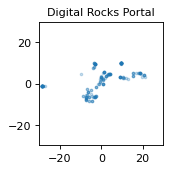

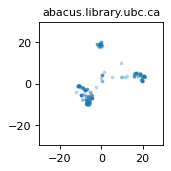

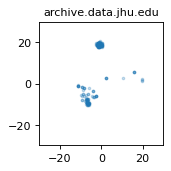

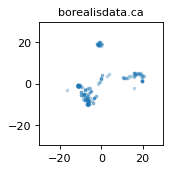

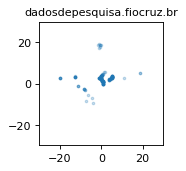

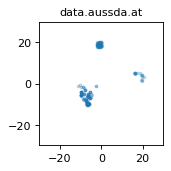

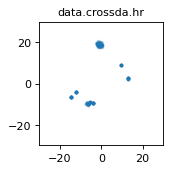

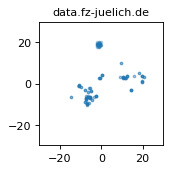

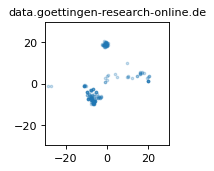

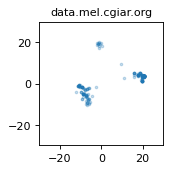

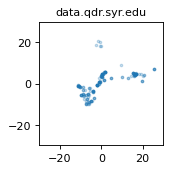

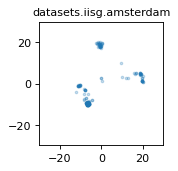

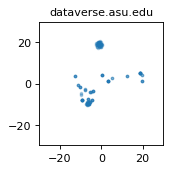

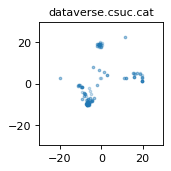

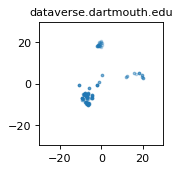

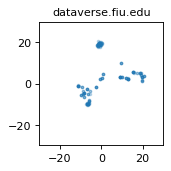

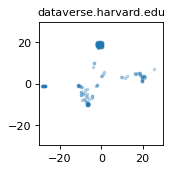

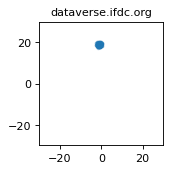

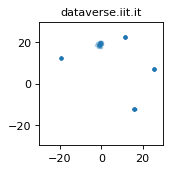

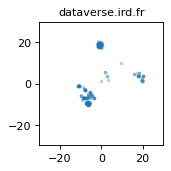

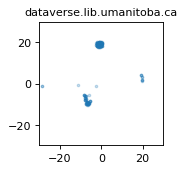

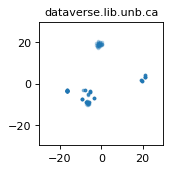

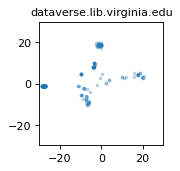

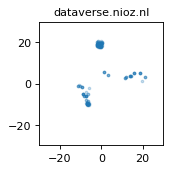

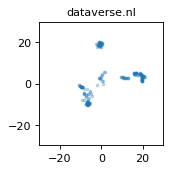

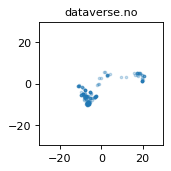

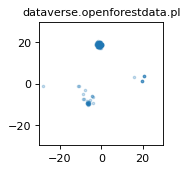

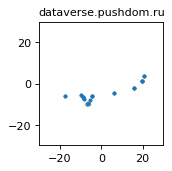

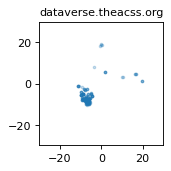

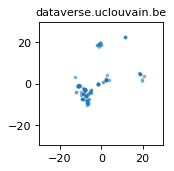

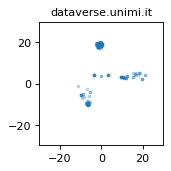

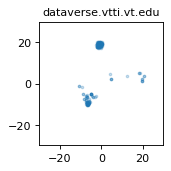

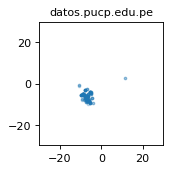

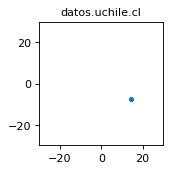

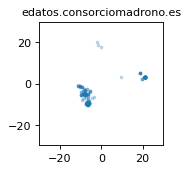

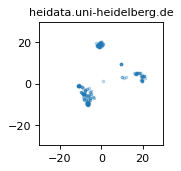

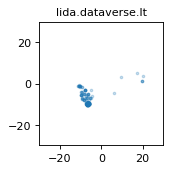

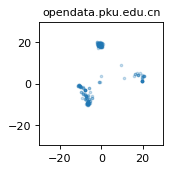

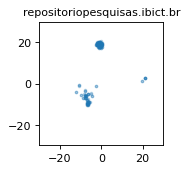

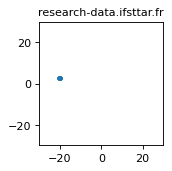

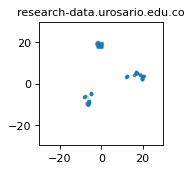

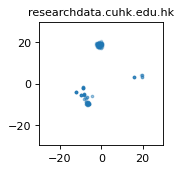

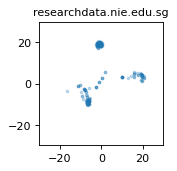

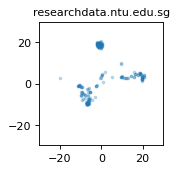

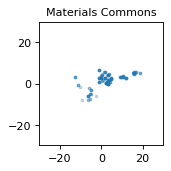

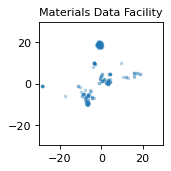

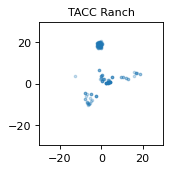

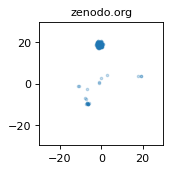

In [42]:
# Remap some abbreviated names to display full name
mapping = {
    "mc": "Materials Commons",
    "ranch": "TACC Ranch",
    "aws-open-data": "AWS Open Data",
    "arecibo": "Arecibo Observatory",
    "mdf": "Materials Data Facility",
    "digitalrocksportal": "Digital Rocks Portal"
}

from matplotlib.pyplot import figure


for key in samples["catalog"].unique():
    
    filtered = (samples["catalog"] == key)

    slice_to_visualize = data_to_cluster[filtered]
    embedding_to_visualize = embedding[filtered]
    samples_to_visualize = samples[filtered]
    
    figure(figsize=(2, 2), dpi=80)

    plt.scatter(
        embedding_to_visualize[:, 0], 
        embedding_to_visualize[:, 1],
        #c=digits.target, 
        cmap='Spectral', 
        s=5,
        alpha=0.25
    )
    
    plt.xlim([-30, 30])
    plt.ylim([-30, 30])
    
    if key in mapping:
        key = mapping[key]
    
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{key.replace("http://", "")}', fontsize=10);
        
    plt.show()